In [15]:
import csv
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from math import ceil
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D, Dropout
from tools import read_image_rgb, remove_noise, resize_image

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
samples = []
def read_csv_file(file, path):
    count = 0
    with open(file) as csv_file:
        reader = csv.reader(csv_file)
        for line in reader:
            if count != 0:
                angle = float(line[3])
                
                center_image_path = line[0].split('/')[-1]
                center_image_path = path + center_image_path
                samples.append([center_image_path, angle])
                
                left_image_path = line[1].split('/')[-1]
                left_image_path = path + left_image_path
                samples.append([left_image_path, adjust_left_angle(angle)])
                
                right_image_path = line[2].split('/')[-1]
                right_image_path = path + right_image_path
                samples.append([right_image_path, adjust_right_angle(angle)])
                
            count += 1
            
    print("Total Images Added: {} x 3".format(count))
    return count
    
def read_image_rgb(image_path):    
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def remove_noise(image):
    return cv2.GaussianBlur(image, (3,3), 0)

def resize_image(image):
    image = image[50:140,:,:]
    image = cv2.resize(image,(200, 66))
    return image

def flip_image(image, measurement):
    if(abs(measurement) > 0.15):
        image       = cv2.flip(image, 1)
        measurement = measurement * -1.0
    return (image, measurement)

def adjust_left_angle(measurement):
    measurement = measurement + 0.2 + 0.5 * random.random()
    measurement = min(measurement, 1)
    return measurement
    
def adjust_right_angle(measurement):
    measurement = measurement - 0.2 - 0.5 * random.random()
    measurement = max(measurement, -1)
    return measurement
    
def sort_images():
    pass

def normalize(samples):
    print("Total: " + str(len(samples)))
    right, left, straight, test = [], [], [], []
    for sample in samples:
        if(float(sample[3]) > .15):
            right.append(sample)
        elif(float(sample[3]) < -.15):
            left.append(sample)
        elif(float(sample[3]) == 0):
            test.append(sample)
        else:
            straight.append(sample)
            
    print("Total left    : "+ str(len(left)))
    print("Total straight: "+ str(len(straight)))
    print("Total right   : "+ str(len(right)))
    print("Total test   : "+ str(len(test)))
    
    samples = right
    samples = samples + left # random.sample(left, len(right))
    samples = samples + random.sample(straight, 6000)
    samples = samples + random.sample(test, 6000)
    return samples
    
def generator(samples, batch_size=32):
    num_samples = len(samples)

    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = read_image_rgb(batch_sample[0])
                center_image = remove_noise(center_image)
                center_image = resize_image(center_image)


                measurement = float(batch_sample[1])

                images.append(center_image)
                angles.append(measurement)
                
                flipped_image, flipped_measurement = flip_image(center_image, measurement)
                images.append(flipped_image)
                angles.append(flipped_measurement)
                
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)



In [4]:
# read_csv_file('./new_data/driving_log.csv')
read_csv_file('./clean_data/driving_log.csv', './clean_data/IMG/')
read_csv_file('./clean_data_backwards/driving_log.csv', './clean_data_backwards/IMG/')
# read_csv_file('./data-original/driving_log.csv', './data-original/IMG/')
# read_csv_file('./run1_correction/driving_log.csv', './run1_correction/IMG/')
# read_csv_file('./run1_correction_backwards/driving_log.csv', './run1_correction_backwards/IMG/')
len(samples)

Total Images Added: 1362 x 3
Total Images Added: 1204 x 3


7692

In [5]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

batch_size=32
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [30]:
model = Sequential()

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66,200,3)))

model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, \
            steps_per_epoch=ceil(len(train_samples)/batch_size), \
            validation_data=validation_generator, \
            validation_steps=ceil(len(validation_samples)/batch_size), \
            epochs=7, verbose=1)

model.save('model.h5')

Instructions for updating:
Colocations handled automatically by placer.


/Users/inis/miniconda3/envs/IntroToTensorFLow/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  """
/Users/inis/miniconda3/envs/IntroToTensorFLow/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  
/Users/inis/miniconda3/envs/IntroToTensorFLow/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  import sys
/Users/inis/miniconda3/envs/IntroToTensorFLow/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/Users/inis/miniconda3/envs/IntroToTensorFLow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` ca

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [6]:
import pandas as pd

df = pd.DataFrame(samples)
df[0]
# df = np.array(samples)
# df['image'] = np.array(temp[:,0])
# df['steering_angle'] = temp[:,3]
# df = df.iloc[1:]
# df['steering_angle'] = pd.to_numeric(df['steering_angle'])
df.head(5)

,0,1
0,./clean_data/IMG/center_2020_05_29_15_54_55_12...,0.000000
1,./clean_data/IMG/left_2020_05_29_15_54_55_120.jpg,0.686602
2,./clean_data/IMG/right_2020_05_29_15_54_55_120...,-0.332485
3,./clean_data/IMG/center_2020_05_29_15_54_55_21...,0.000000
4,./clean_data/IMG/left_2020_05_29_15_54_55_216.jpg,0.566706


In [7]:
df[1].max()

0.979725261881506

In [8]:
df[1].min()

-1.0

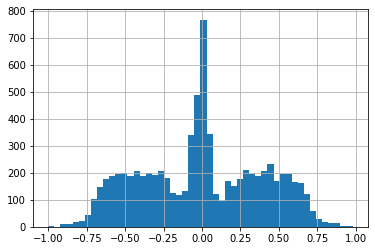

In [9]:
df[1].hist(bins=50);

In [10]:
print("left :" + str(len(df[df[1] < -0.15])))
print("right:" + str(len(df[df[1] >  0.15])))

left :2663
right:2685


In [11]:
def random_image_brigtness_generator(image_path):
    image = read_image(image_path)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    h, s, v = cv2.split(hls)

    value = 30
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HLS2RGB)
    return img

In [16]:
image = random_image_brigtness_generator(samples[0][0])
plt.imshow(samples[0][0])

NameError: name 'read_image' is not defined

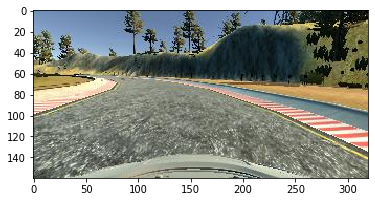

In [21]:
plt.imshow(read_image_rgb(samples[0][0]))
# samples[0][0]

In [22]:
def plot_image_color(img, output_path=None):
    f, ax1 = plt.subplots(1, 1, figsize=(20, 12))
    ax1.imshow(img)
    
    if(output_path):
        plt.savefig(output_path, dpi=100)

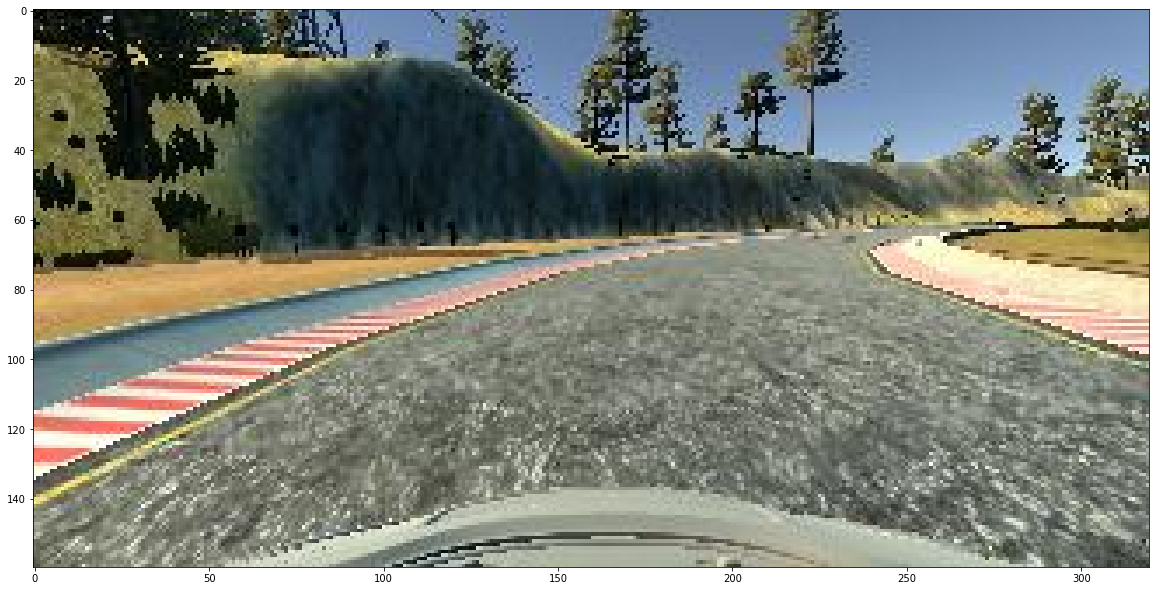

In [29]:
image = samples[0][0]
image = read_image_rgb(image)
image = cv2.flip(image, 1)
plot_image_color(image, './examples/flip.png')